# Rocket Lab Technical Test
## Tim Holthuijsen

### imports
First of all, we are going to need some Python libraries for this analysis. We import the necessary ones below

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.optimize import curve_fit
from numpy import arange
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score


The goal of this exercise is to accurately predict the ejection velocity of for the range of payload masses from 3kg to 15kg, as well as obtain the physical spring parameters k (spring constant) and b (damping coefficient) of a 2-spring nanosatelite dispenser (CSD). For this, we use the mass-spring-damper model, defined as follows:

$ m\ddot{x} = -b\dot{x} - kx $


where m is the spacecraft mass in kg, b is the damping coefficient in Ns/m, k is the spring constant in N/m and x is the displacement of the spring in m

Additionally, we have been given a graph representing ejection velocity as a function of payload mass, as shown below. In this graph, we are specifically interested in the 3U dispenser containing 2 springs, or the green line in the figure

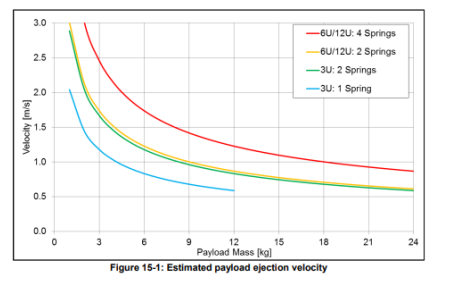

### Data extraction
In order to make this visual data useable, we visually extract datapoints from this graph using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/), as shown below:

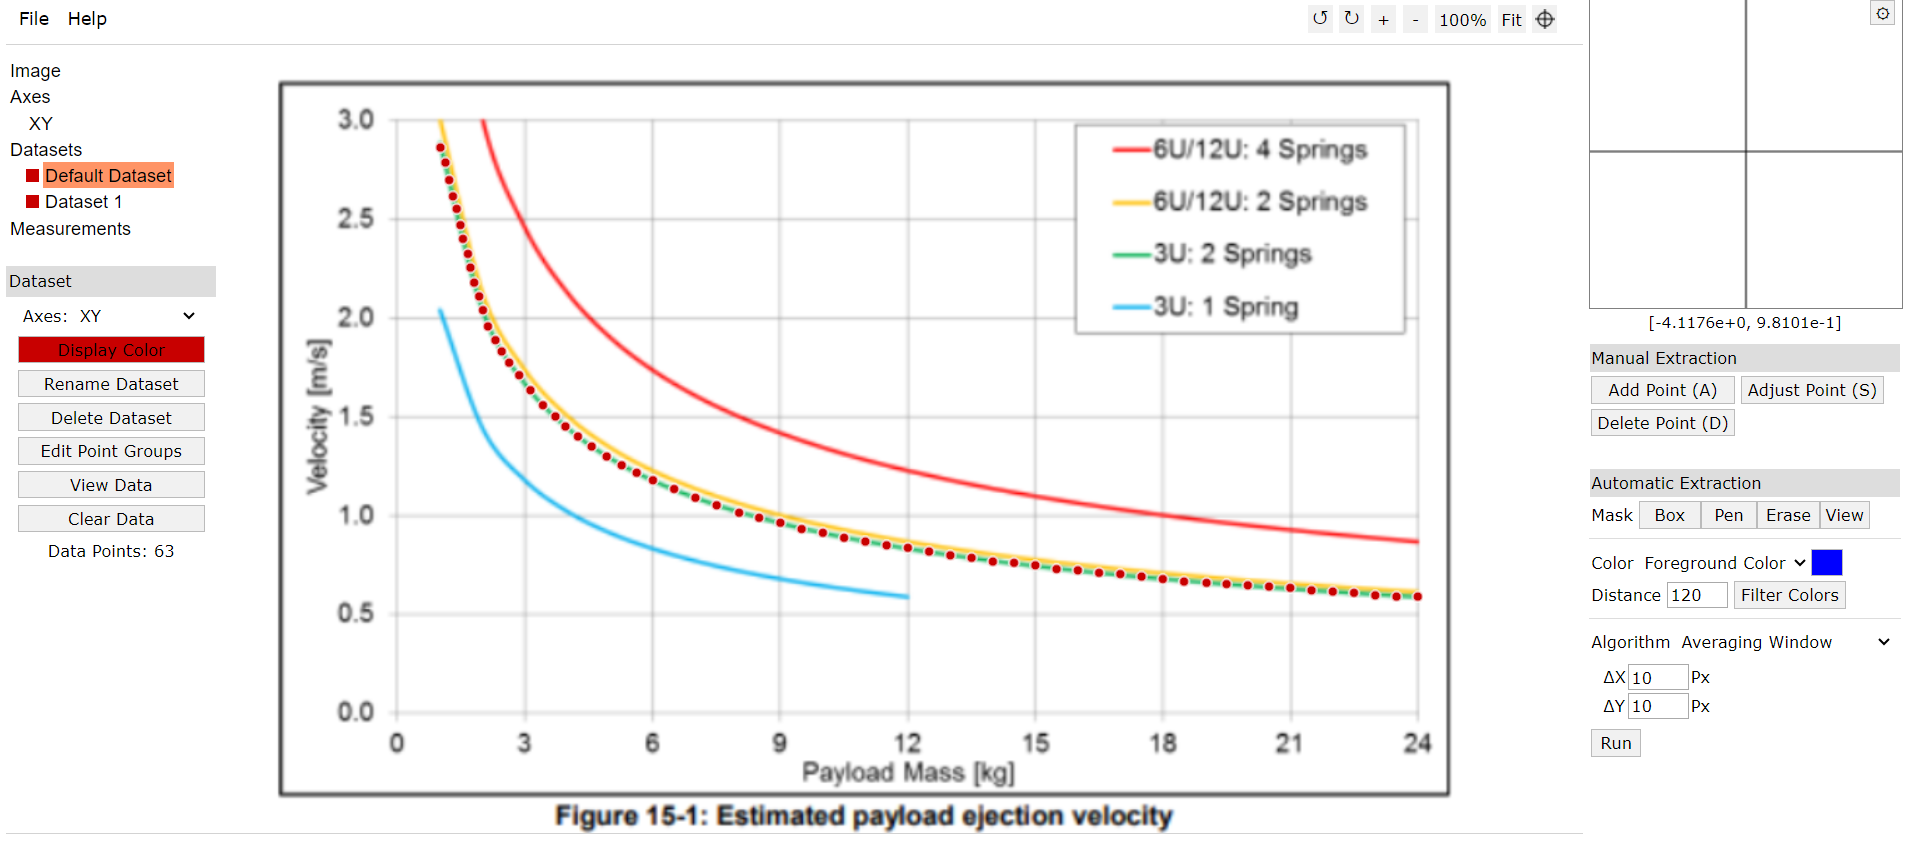

## Loading the data
Now that the data has been extracted (and saved as a csv), we can load it into Python as a pandas dataframe

In [2]:
#Load the data
data = pd.read_csv('TwoSpringsData.csv',names = ['mass', 'velocity'])

In [3]:
#have a quick look at the data
data

,mass,velocity
0,1.000000,2.860759
1,1.117647,2.784810
2,1.205882,2.696203
3,1.294118,2.613924
4,1.382353,2.550633
...,...,...
58,22.000000,0.613924
59,22.500000,0.607595
60,23.000000,0.594937
61,23.500000,0.588608


### Visual confirmation
To check that everything went right, we quickly plot our extracted data to confirm that it still has the same shape as the original CSD 2U Velocity/Mass line (it does)

In [4]:
#we store the individual data columns into some easily-accesible variables
mass_data = data['mass']
v_data = data['velocity']

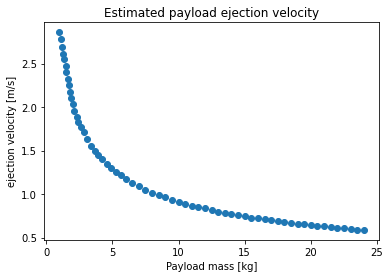

In [5]:
#Start with plotting the original data
plt.scatter(mass_data, v_data)
plt.title("Estimated payload ejection velocity")
plt.xlabel("Payload mass [kg]")
plt.ylabel("ejection velocity [m/s]")
plt.show()

# Parameter estimation
Now that we have our data in the right shape, we can start optimizing a function to fit our curve

### Let's fit an accurate function to the velocity-mass graph
Using mathematical analysis (included further below) of the mass-springer-damper model, the exact format of the velocity-mass function is found to be of the shape:

$$v = \frac{a}{\sqrt{bm}}$$

With v being velocity in meters/second, m being payload mass in kg, and a and b being constants. Using this function template, we can fit function parameters for a and b to create a curve to exactly fit our extracted velocity-mass curve. This is done below:

In [6]:
# Define the shape of the function
def model(x, a, b):
    result = a / (b*x)**0.5 #This is the function listed above
    return result

In [7]:
#Optimize the parameters to fit the curve
parameters, covariance_matrix = curve_fit(model, mass_data, v_data)

In [8]:
parameters

array([ 36.38281008, 156.09995452])

In [9]:
#Have a quick look at the parameters and the covariance matrix
print('  a is ', parameters[0], '\n ', 'b is ', parameters[1], '\n')
print(' covariance matrix is: ', '\n',covariance_matrix)

  a is  36.38281007546312 
  b is  156.09995451828834 

 covariance matrix is:  
 [[5.25257081e+13 4.50721685e+14]
 [4.50721685e+14 3.86763063e+15]]


In [10]:
# display the final function with optimized parameters
a, b= parameters #store the parameters
print('v = %.5f / sqrt(%.5f m) ' % (a, b))

v = 36.38281 / sqrt(156.09995 m) 


Now let's plot our prediction curve next to the original one

In [11]:
#Let's store the original data in a slightly more plot-like way
x = mass_data
y = v_data

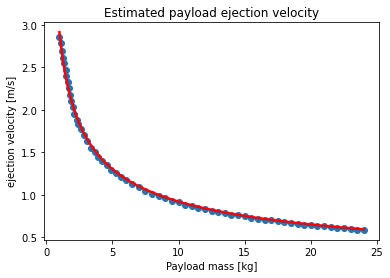

In [12]:
#Start by plotting the original data
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
#x_line = arange(min(x), max(x), 1)
# calculate the output of our fitted function for the range
v_predicted = model(x, a, b)
# create a line plot for the fitted function
plt.plot(x, v_predicted, color='red', linewidth = 2.5)

plt.title("Estimated payload ejection velocity")
plt.xlabel("Payload mass [kg]")
plt.ylabel("ejection velocity [m/s]")

plt.show()

# A perfect fit!
As you can tell from the graph above, the red fitted curve fits the blue curve containing the original data almost exactly. This shows that we have acquired an accurate approximation of the velocity-mass function using our fitted curve, and, knowing either velocity or mass, we can now always calculate the other using the function:

$$v = \frac{36.38281}{\sqrt{156.09995m}}$$

With this, we have largely completed the task, stating as a goal to "accurately predict the ejection velocity of the dispenser for the range of spacecraft (payload) masses from 3kg to 15kg."

However, since k and b are asked, we will continue to analytically derive these.

First, however, we test the accuracy of our model a little more rigorously than a simple visual test. We compute some model evaluation parameters: Mean squared error, R squared, and the explained variance 

Let's calculate our eveluation parmeters:

In [13]:
# given values are equal to v_data
real = v_data
# calculated values are equal to v_predicted 
pred = v_predicted
  
#Calculation of Mean Squared Error (MSE)  
mse = mean_squared_error(real, pred)
#R squared
r_squared = r2_score(real, pred)
#and finally, calculate explained variance
explained_variance = explained_variance_score(real,pred)

In [14]:
print('mse is: ', mse, ' :this should be as close to 0 as possible')
print('R squared is: ', r_squared,' :this should be as close to 1 as possible')
print('explained variance is: ', explained_variance,' :this should be as close to 1 as possible')

mse is:  0.0005631950448297956  :this should be as close to 0 as possible
R squared is:  0.9987668111134123  :this should be as close to 1 as possible
explained variance is:  0.9988197605719936  :this should be as close to 1 as possible


### Incredible fit
As you can tell from the values above, our model is an incredibly accurate fit with the real data.
### However....
I think we might be able to do a bit better still. I have something specific in mind:

Rather than taking the square root of bm in our predicting function, let's optimize the power of the denominator as well and see if it improves things even further

formula is: v = 0.7615416313 / (0.0707200048 m)**0.5099012268 


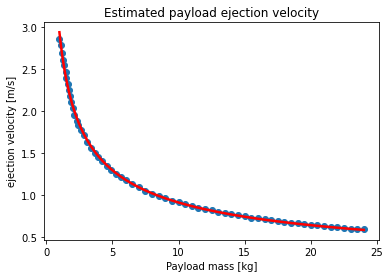

In [15]:
# Define the shape of the new function
def model2(x, a, b, c):
    result = a / (b*x)**c # <---- This is what's different! rather than using the power of 0.5, we define a new variable c
    return result

#Optimize the new parameters to fit the curve
parameters2, covariance_matrix = curve_fit(model2, mass_data, v_data)

# display the final function with optimized parameters
a, b, c= parameters2 #store the parameters
print('formula is: v = %.10f / (%.10f m)**%.10f ' % (a, b,c))

#Start by plotting the original data
plt.scatter(x, y)

# calculate the output of our fitted function for the range
v_predicted2 = model2(x, a, b,c)
# create a line plot for the fitted function
plt.plot(x, v_predicted2, color='red', linewidth = 2.5)

plt.title("Estimated payload ejection velocity")
plt.xlabel("Payload mass [kg]")
plt.ylabel("ejection velocity [m/s]")

plt.show()

As you can tell, the fit is still great. Now, let's see if it is even better than our previous model:

In [16]:
# calculated values are equal to v_predicted2 for the new model
pred = v_predicted2
  
#Calculation of Mean Squared Error (MSE)  
mse2 = mean_squared_error(real, pred)
#R squared
r_squared2 = r2_score(real, pred)
#and finally, calculate explained variance
explained_variance2 = explained_variance_score(real,pred)

In [17]:
print('mse is: ', mse2, ' previous mse was: ', mse)
print('R squared is: ', r_squared2,' previous R squared was: ', r_squared)
print('explained variance is: ', explained_variance2,' previous explained variance was: ', explained_variance)

mse is:  0.00041797667569404436  previous mse was:  0.0005631950448297956
R squared is:  0.9990847856421134  previous R squared was:  0.9987668111134123
explained variance is:  0.9990854272900126  previous explained variance was:  0.9988197605719936


### Newest model is an even better fit
The evaluation parameters of this latest iteration of the model show that this version is even more accurate than the previous iteration. Our final formula comes to:
$$v = \frac{0.76154}{{0.07072m}^{0.50990}}$$

In [18]:
explained_variance

0.9988197605719936

# Analysis
We have the following equation: 
$ m\ddot{x} = -b\dot{x} - kx $

Our model currently has a M

In [19]:
data

,mass,velocity
0,1.000000,2.860759
1,1.117647,2.784810
2,1.205882,2.696203
3,1.294118,2.613924
4,1.382353,2.550633
...,...,...
58,22.000000,0.613924
59,22.500000,0.607595
60,23.000000,0.594937
61,23.500000,0.588608


In [20]:
data[1:40]

,mass,velocity
1,1.117647,2.784810
2,1.205882,2.696203
3,1.294118,2.613924
4,1.382353,2.550633
5,1.470588,2.468354
6,1.529412,2.398734
7,1.647059,2.322785
8,1.705882,2.253165
9,1.794118,2.177215
10,1.911765,2.107595


In [21]:
print(type(m.e))

<class 'float'>


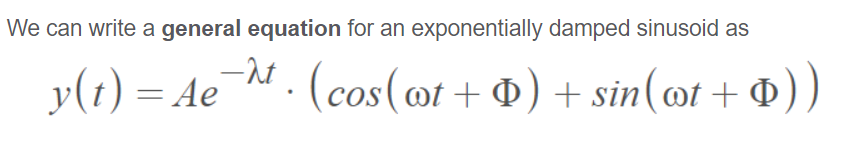

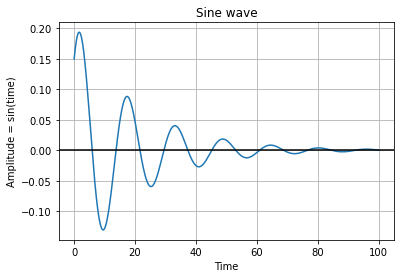

In [23]:
# Get x values of the sine wave

time        = np.arange(0, 100, 0.1);

 

# Amplitude of the sine wave is sine of a variable like time

amplitude   = 0.15 * m.e ** (-0.05*time) * (np.cos(0.4*time) + np.sin(0.4*time))

 

# Plot a sine wave using time and amplitude obtained for the sine wave

plt.plot(time, amplitude)

 

# Give a title for the sine wave plot

plt.title('Sine wave')

 

# Give x axis label for the sine wave plot

plt.xlabel('Time')

 

# Give y axis label for the sine wave plot

plt.ylabel('Amplitude = sin(time)')

 

plt.grid(True, which='both')

 

plt.axhline(y=0, color='k')

 

plt.show()

 

# Display the sine wave

plt.show()

In [ ]:
time

### reading in the visually extracted data

In [ ]:
# This is getting close, but it does not fit he curve yet. Rather than a simple polynomial, we see if a rational function might fit better
def objective2(x, a, b, c):
    return 0.15 * 2.71828**(x*a) + b

In [ ]:
# curve fit again 
popt2, _ = curve_fit(objective2, x, y)

In [ ]:
popt2

In [ ]:
# plot input vs output
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
a = popt2[0]
b = popt2[1]
c = popt2[2]
y_line = objective2(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
plt.show()

# Images

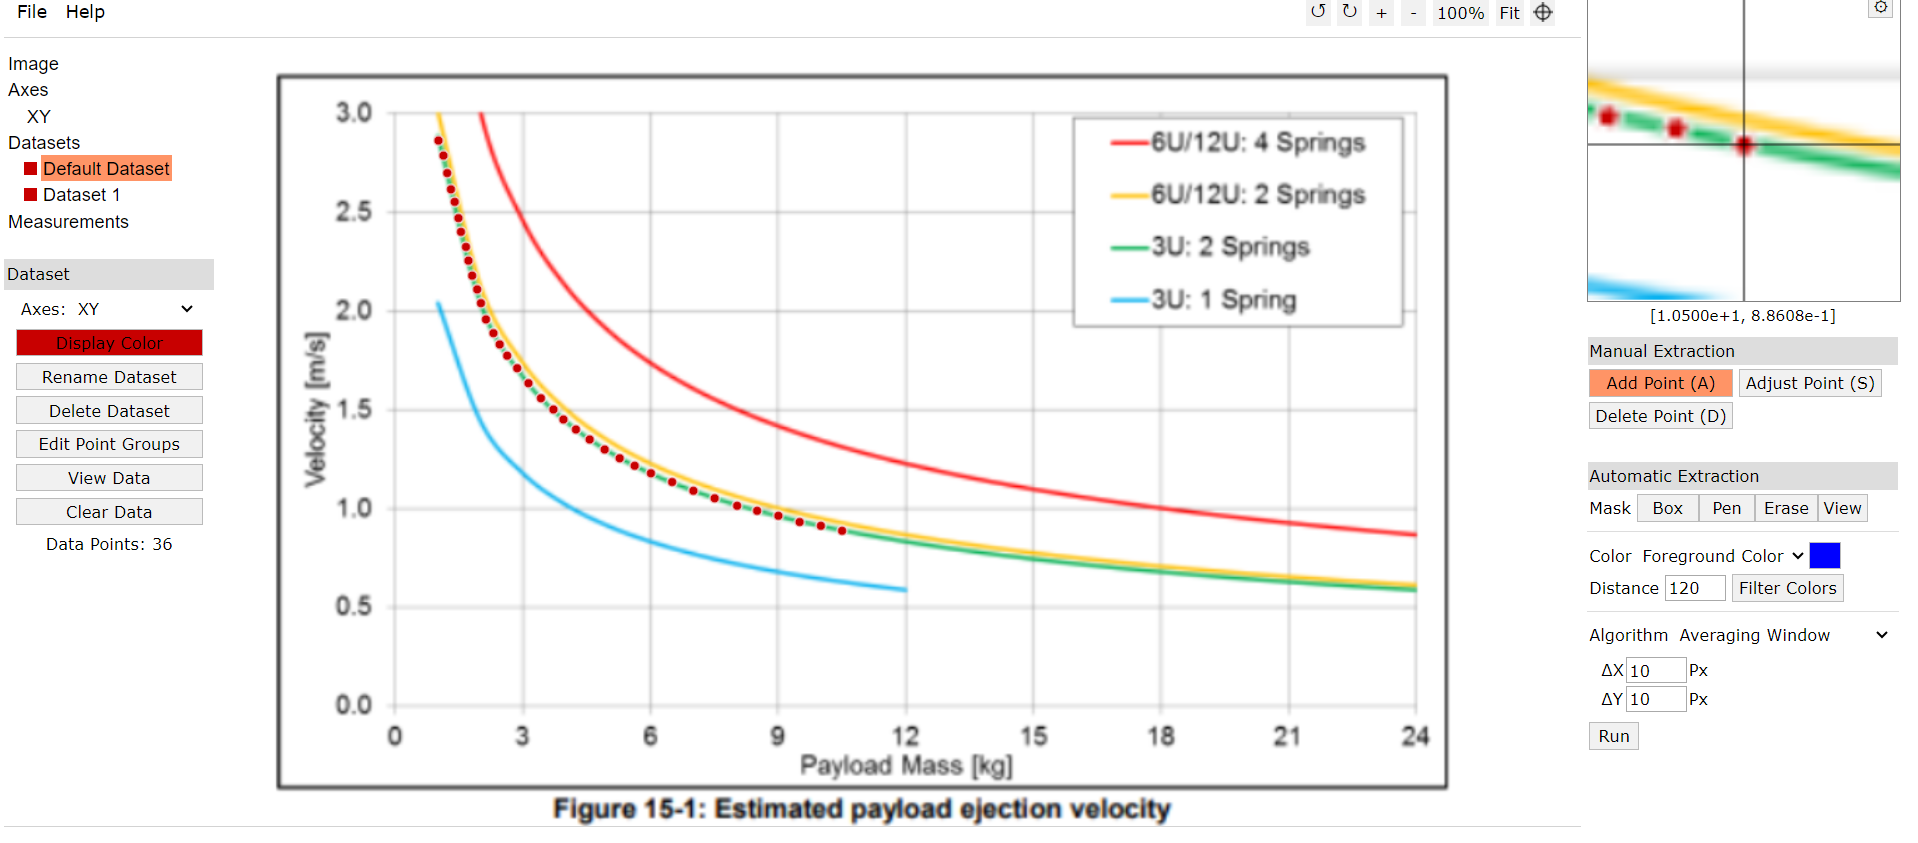